In [1]:
from lib.data import *
import time
data, raw = get_default_oec_rca_raw_data()

Se cargaron los datos desde ../data/default_oce_2018-2020.pkl


In [2]:
data

HS4 ID,10101,10102,10103,10104,10105,10106,10201,10202,10203,10204,...,209612,209613,209615,209616,209617,209618,219701,219703,219705,219706
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,8.000000e+02,2.184000e+05,0.000000,1.724228e+06,0.000000e+00,1.099465e+06,0.000000e+00,4.637150e+04,3.450000e+02,1.148750e+05,...,2.600000e+01,0.000000e+00,6.233333e+01,5.000000e+00,6.101667e+03,0.000000e+00,1.756857e+05,6.754533e+04,2.274247e+05,1.522979e+06
Albania,0.000000e+00,0.000000e+00,0.000000,3.581650e+04,1.183000e+04,8.327063e+05,9.722367e+04,0.000000e+00,3.065600e+04,0.000000e+00,...,3.073500e+03,1.507100e+04,4.950633e+04,1.920000e+02,2.112667e+03,1.967333e+03,2.395257e+05,4.790267e+05,3.601623e+05,1.803333e+03
Algeria,2.875700e+04,0.000000e+00,0.000000,0.000000e+00,8.900000e+01,1.234467e+04,0.000000e+00,8.204867e+04,1.078870e+05,0.000000e+00,...,2.640000e+02,7.744000e+03,2.900000e+01,5.079500e+03,2.712400e+04,1.000400e+04,4.463967e+04,1.717795e+05,9.760267e+04,2.925467e+04
Angola,5.610667e+03,5.046833e+04,2714.500000,3.086350e+04,3.479000e+03,1.714347e+05,1.573000e+03,7.756967e+04,4.146267e+04,1.649000e+03,...,5.826667e+02,2.853333e+02,2.403000e+03,4.300000e+01,1.573073e+05,4.772000e+03,8.091333e+04,1.450633e+04,3.053633e+04,1.743685e+05
Argentina,2.812502e+07,9.218183e+05,127334.333333,4.128233e+04,1.483340e+06,1.419036e+06,7.537525e+08,1.877181e+09,3.480726e+07,1.810096e+07,...,3.178933e+04,1.094200e+04,2.651812e+06,3.153490e+06,2.068500e+05,2.232800e+04,5.815408e+07,2.318448e+06,1.165519e+06,1.071100e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,1.202633e+05,7.505000e+04,0.000000,0.000000e+00,0.000000e+00,1.067140e+05,0.000000e+00,0.000000e+00,4.138000e+03,0.000000e+00,...,2.407000e+03,6.929333e+03,3.712200e+04,2.650000e+02,4.078333e+03,2.865000e+02,4.390377e+06,3.857757e+06,3.309170e+05,6.523000e+03
Vietnam,4.014293e+05,1.014512e+06,502436.000000,0.000000e+00,7.655200e+05,1.436885e+07,6.721567e+04,3.728624e+06,4.871570e+07,2.421943e+05,...,8.696550e+06,3.750111e+07,9.260660e+06,2.107415e+07,9.951671e+06,2.088057e+06,4.103189e+06,1.263628e+06,9.182307e+05,1.827807e+05
Yemen,0.000000e+00,1.237660e+05,0.000000,5.112650e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,5.910000e+02,0.000000e+00,2.725000e+02,0.000000e+00,0.000000e+00,0.000000e+00,3.644000e+03,3.275200e+04,5.020667e+03,4.506717e+05


In [3]:
import economic_complexity as ecplx

rca = ecplx.rca(data)
M = build_M_from(rca)

In [4]:
#from informe import SimuladorEstatico, SimuladorDinamico, SimuladorComplejo, PaisNaive
from informe import *
from lib.utils import *#correr_simulacion_mostrando, cantidad_descubrimientos_iteracion, cantidad_descubrimientos_paises, pais_collector

De forma similar al trabajo anterior:

https://cnet.fi.uba.ar/netscix23/abstracts/Dynamics%20matter:%20A%20simulation%20framework%20to%20study%20diffusion%20processes%20on%20a%20Dynamic%20Product%20Space.pdf

Vamos a comparar la diferencia de productos descubiertos si el sistema es o no dinámico, variando el $\Omega$. 
Mostraremos evolución, tomando dos paises distintos, Argentina y Alemania, .

Como en el paper citado, la convergencia está en el orden de las unidades (3-5 iteraciones aprox), pero nuestros agentes pueden tardar hasta un máximo de 10 iteraciones en alcanzar un producto muy complejo, en este trabajo se iterara diez veces esa cantidad.

In [5]:
cant_paises = len(M.index.to_list())

# 0.1..0.9
def simular_para(sim_clase_estatica= SimuladorComplejoEstatico, pais_clase_estatico = PaisComplejo,
                 sim_clase_dinamica=SimuladorComplejo, pais_clase_dinamico = PaisComplejo,
                 omegas = [], iteraciones=15, mostrar=False):
    for omega in omegas:
        estatico = sim_clase_estatica(lambda step: step >= iteraciones, pais_clase_estatico, M.copy(deep=True), omega)
        dinamico = sim_clase_dinamica(lambda step: step >= iteraciones, pais_clase_dinamico, M.copy(deep=True), omega)
        start = time.time()
        historia_estatico = correr_simulacion_mostrando(estatico, mostrar, 
                                                        collector=default_collector, 
                                                        formatter=default_formatter)
        historia_dinamico = correr_simulacion_mostrando(dinamico, mostrar)
        print(f"elapsed: {time.time() - start} segs")
        yield (historia_estatico, historia_dinamico, omega)

In [6]:
resultados_paper = list(simular_para(
    sim_clase_dinamica=SimuladorDinamico, sim_clase_estatica=SimuladorEstatico,
    pais_clase_dinamico=PaisNaive, pais_clase_estatico=PaisNaive,
    omegas=[x/10.0 for x in range(1,10)], iteraciones=5))

proximidad calculada en: 0.13788485527038574
paises creados en: 0.0003447532653808594
proximidad calculada en: 0.12655043601989746
paises creados en: 0.00023031234741210938
empezando simulación: 2024-07-01 11:21:53
empezando simulación: 2024-07-01 11:22:02
elapsed: 18.951131105422974 segs
proximidad calculada en: 0.13937044143676758
paises creados en: 0.0003390312194824219
proximidad calculada en: 0.14240217208862305
paises creados en: 0.00016808509826660156
empezando simulación: 2024-07-01 11:22:12
empezando simulación: 2024-07-01 11:22:21
elapsed: 19.13594698905945 segs
proximidad calculada en: 0.13937640190124512
paises creados en: 0.00028824806213378906
proximidad calculada en: 0.13514924049377441
paises creados en: 0.00018978118896484375
empezando simulación: 2024-07-01 11:22:31
empezando simulación: 2024-07-01 11:22:41
elapsed: 19.59509778022766 segs
proximidad calculada en: 0.1251845359802246
paises creados en: 0.0002655982971191406
proximidad calculada en: 0.1266613006591797
pa

In [7]:
resultados_nuevos = list(simular_para(
    sim_clase_dinamica=SimuladorComplejo, sim_clase_estatica=SimuladorComplejoEstatico,
    pais_clase_dinamico=PaisComplejo, pais_clase_estatico=PaisComplejo,
    omegas=[x/10.0 for x in range(1,10)], 
    iteraciones=35))

proximidad calculada en: 0.18673300743103027
paises creados en: 0.013129472732543945
proximidad calculada en: 0.1801319122314453
paises creados en: 0.0139923095703125
empezando simulación: 2024-07-01 11:23:43
empezando simulación: 2024-07-01 11:24:07
elapsed: 48.49709486961365 segs
proximidad calculada en: 0.16807270050048828
paises creados en: 0.018364906311035156
proximidad calculada en: 0.17916369438171387
paises creados en: 0.01846003532409668
empezando simulación: 2024-07-01 11:24:32
empezando simulación: 2024-07-01 11:24:55
elapsed: 48.889037132263184 segs
proximidad calculada en: 0.17605805397033691
paises creados en: 0.012560367584228516
proximidad calculada en: 0.1838855743408203
paises creados en: 0.013973236083984375
empezando simulación: 2024-07-01 11:25:22
empezando simulación: 2024-07-01 11:25:45
elapsed: 49.18452072143555 segs
proximidad calculada en: 0.1706397533416748
paises creados en: 0.012064456939697266
proximidad calculada en: 0.17105960845947266
paises creados en

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

def plot_sps_vs_dps(spd_hist, dps_hist, omega, aclaracion="", saveit=False):
    cant_des_sps = cantidad_descubrimientos_iteracion(spd_hist)
    cant_des_sps_arg = cantidad_descubrimientos_iteracion(spd_hist, ["Argentina"])
    cant_des_sps_ger = cantidad_descubrimientos_iteracion(spd_hist, ["Germany"])
    
    cant_des_dps = cantidad_descubrimientos_iteracion(dps_hist)
    cant_des_dps_arg = cantidad_descubrimientos_iteracion(dps_hist, ["Argentina"])
    cant_des_dps_ger = cantidad_descubrimientos_iteracion(dps_hist, ["Germany"])
    
    fig = plt.figure(figsize=(10, 6))
    fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.plot(range(1,len(spd_hist)+1), cant_des_sps / cant_paises, label='Promedio Mundial - SPS', 
            color = "g", linestyle='dashdot')
    plt.plot(range(1,len(dps_hist)+1),cant_des_dps / cant_paises, label='Promedio Mundial - DPS', 
            color = "g", linestyle='-')
    plt.plot(range(1,len(spd_hist)+1), cant_des_sps_arg, label='Argentina - SPS', 
            color = "r", linestyle='dashdot')
    plt.plot(range(1,len(dps_hist)+1),cant_des_dps_arg, label='Argentina - DPS', 
            color = "r", linestyle='-')
    plt.plot(range(1,len(spd_hist)+1), cant_des_sps_ger, label='Alemania - SPS', 
            color = "b", linestyle='dashdot')
    plt.plot(range(1,len(dps_hist)+1),cant_des_dps_ger, label='Alemania - DPS', 
            color = "b", linestyle='-')
    plt.xlabel('Iteracion')
    plt.ylabel('Cantidad de productos exportados')
    plt.title(f'Productos exportados Dinámico (DPS) y Estático (SPS) con Omega = {omega}')
    plt.legend()
    if saveit:
        savefig(plt, f"dps-vs-sps-evolucion-productos-{aclaracion}-omega-{omega}")
    plt.show()

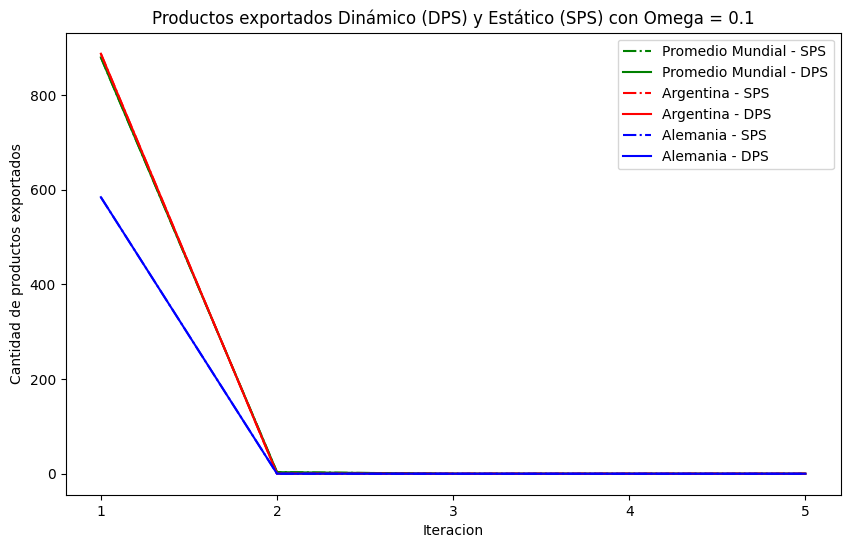

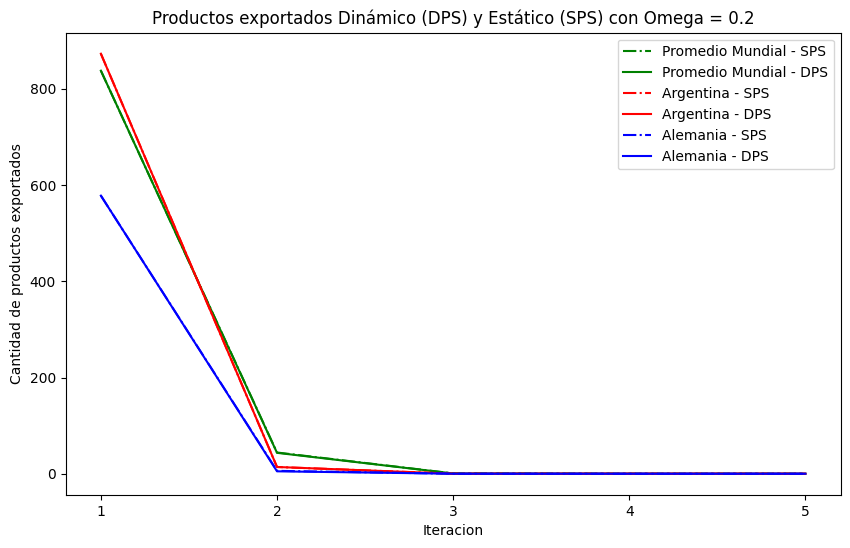

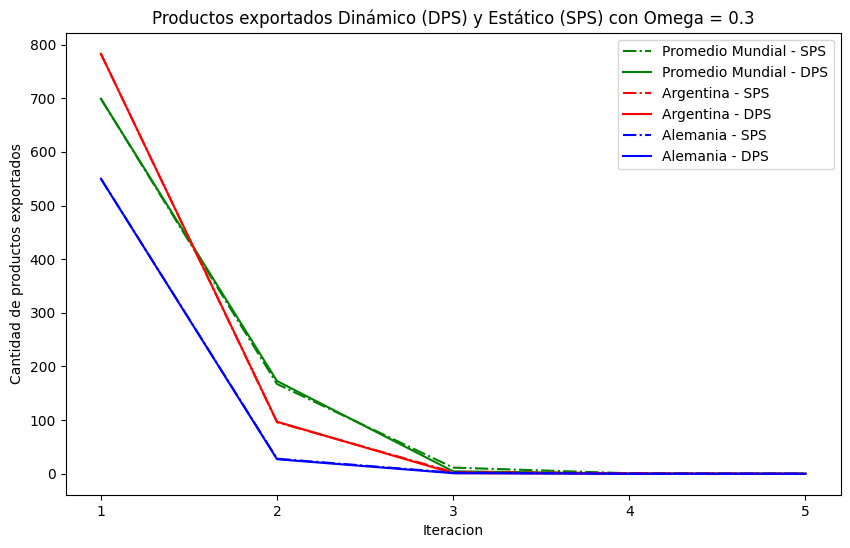

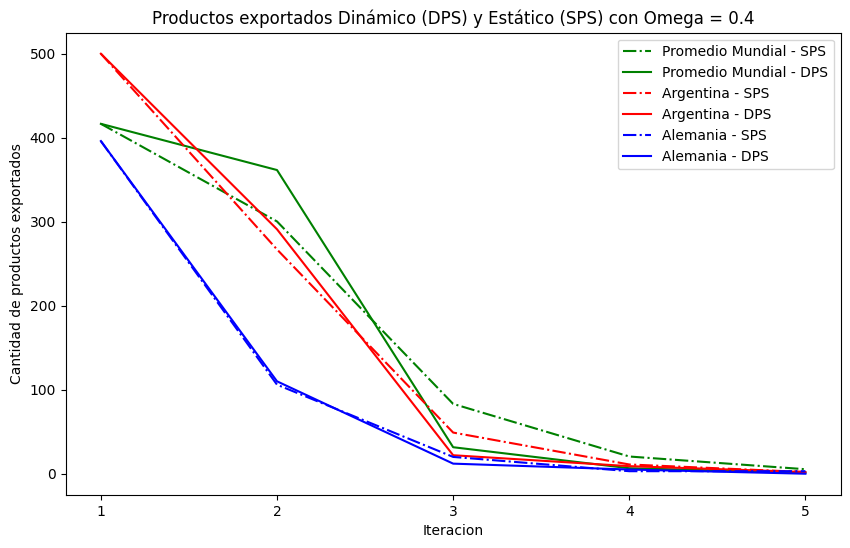

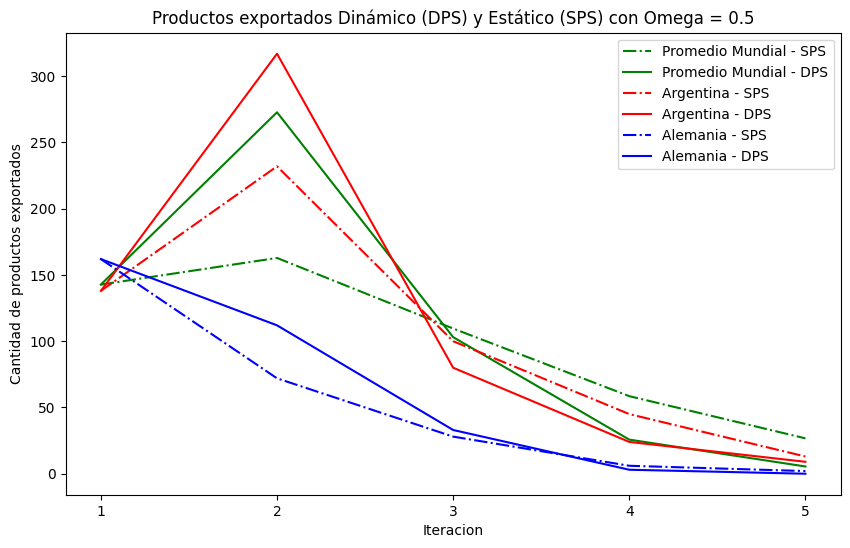

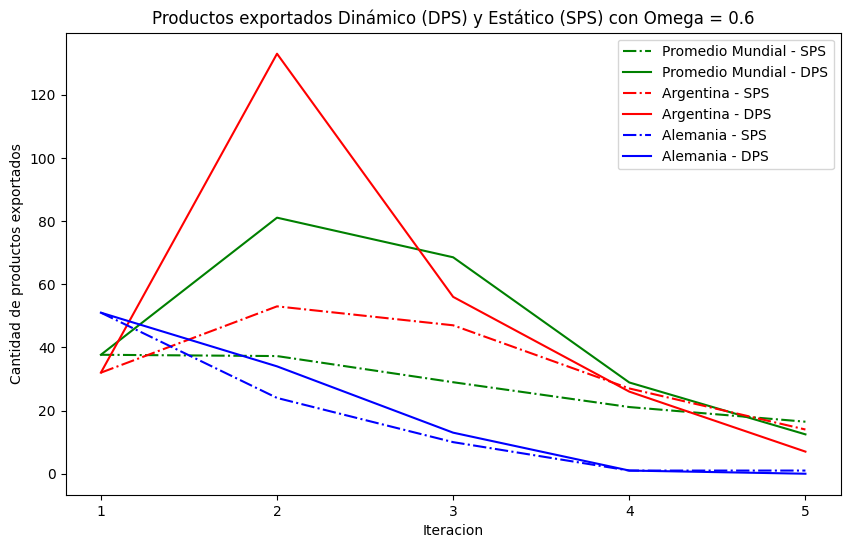

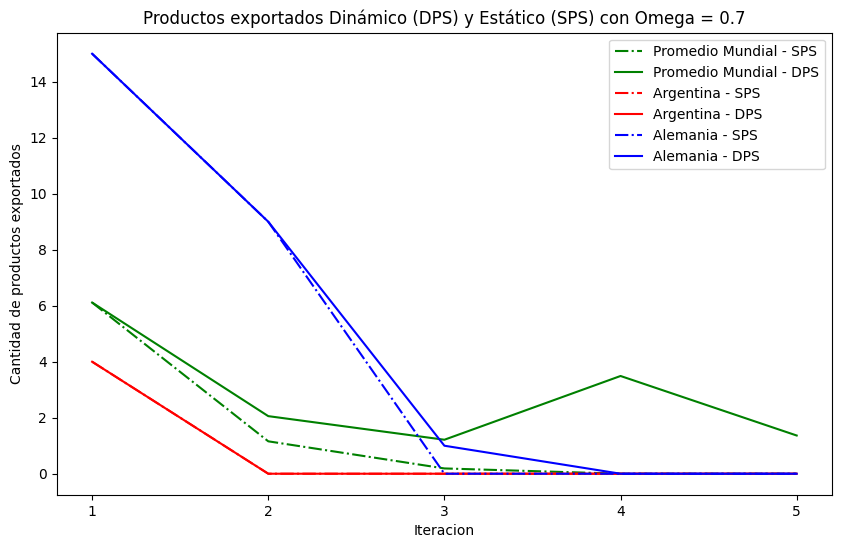

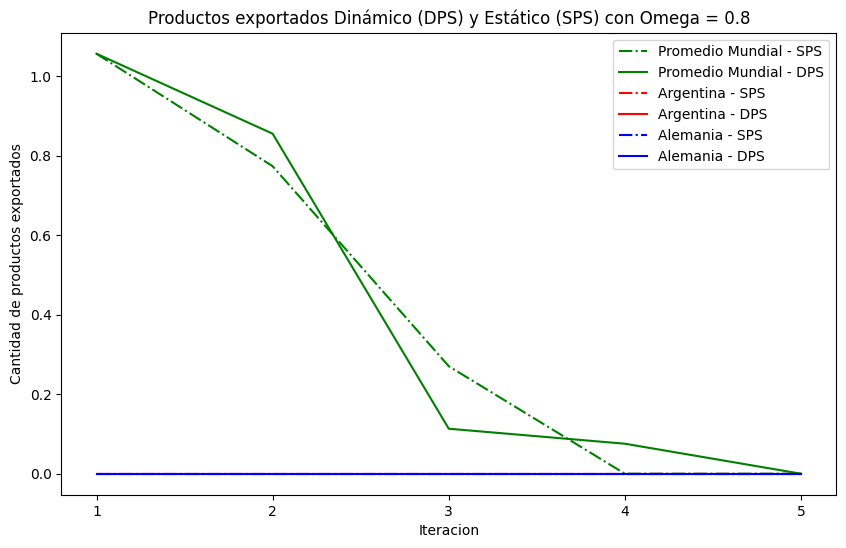

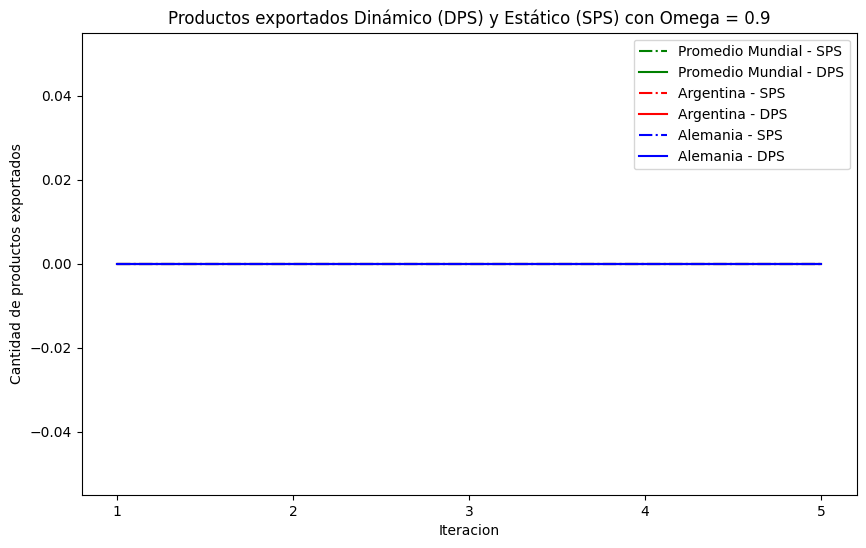

In [41]:
for (spd_hist, dps_hist, omega) in resultados_paper:
    saveit = omega == 0.6
    plot_sps_vs_dps(spd_hist, dps_hist, omega, saveit=saveit, aclaracion="paper")

In [43]:
from matplotlib.ticker import FormatStrFormatter

def plot_dps_vs_sps_boxplot(paises, resultados, aclaracion = "", max_it=None, saveit=False):
    prom_diffs = {}
    for (sps_hist, dps_hist, omega) in resultados:
        mit = max_it if max_it else len(sps_hist)
        sps_desc_por_pais = {p: cantidad_descubrimientos_paises(sps_hist[0:mit])[p] for p in paises}
        dps_desc_por_pais = {p: cantidad_descubrimientos_paises(dps_hist[0:mit])[p] for p in paises}
        
        prom_diffs[omega] = np.array(list(dps_desc_por_pais.values()))
        prom_diffs[omega] -= np.array(list(sps_desc_por_pais.values()))
        prom_diffs[omega] = prom_diffs[omega].astype(float)
    fig = plt.figure(figsize=(10, 6))
    ax = plt.boxplot(prom_diffs.values()) #, tick_labels=list(prom_diffs.keys()))
    fig.gca().set_xticklabels(list(prom_diffs.keys()))
    plt.xlabel('Omega')
    plt.ylabel('SPS <- Diferencia en la cantidad de productos exportados -> DPS')
    plt.title(f'Productos extra exportados con DPS en {mit} iteraciones - {aclaracion}')
    if saveit:
        savefig(plt, f"dps-vs-sps-boxplot_{aclaracion.replace(' ', '-')}-it_{mit}")
    plt.show()

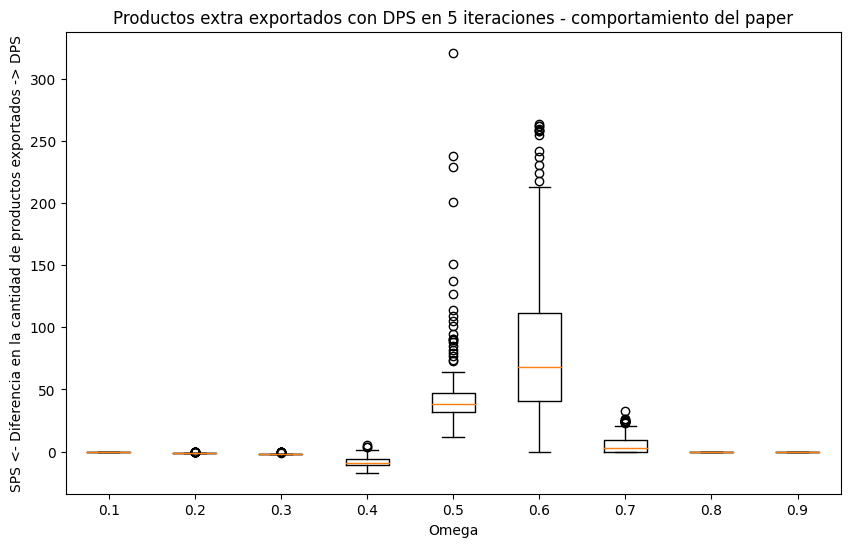

In [53]:
plot_dps_vs_sps_boxplot(list(M.index), resultados_paper, aclaracion=f"comportamiento del paper", saveit=True)

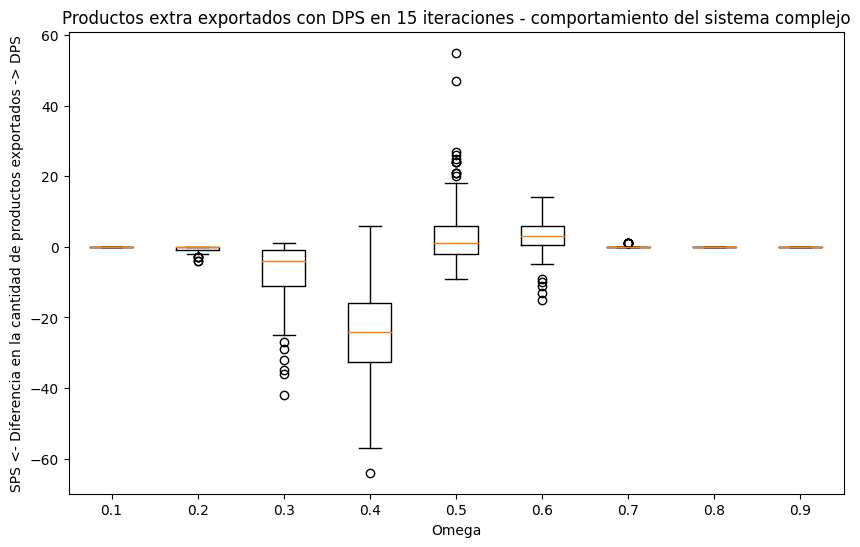

In [54]:
plot_dps_vs_sps_boxplot(list(M.index), resultados_nuevos, f"comportamiento del sistema complejo", max_it=15, saveit=True)

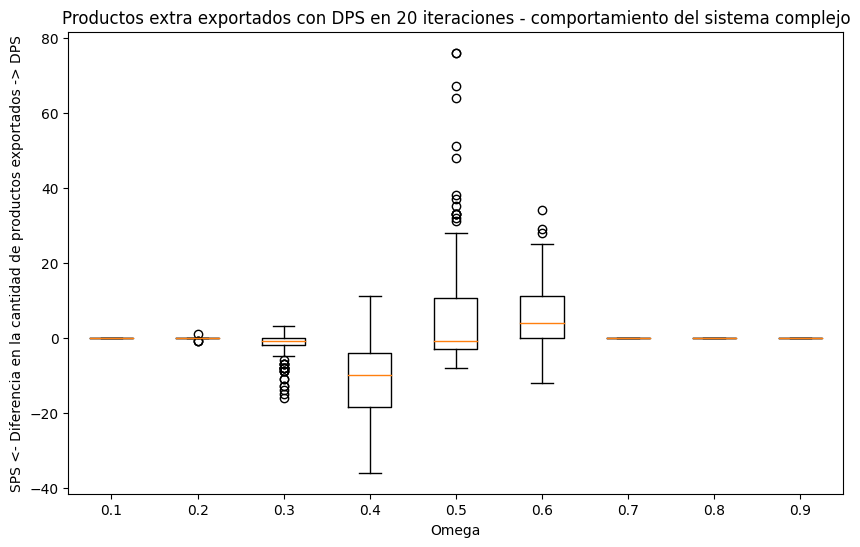

In [55]:
plot_dps_vs_sps_boxplot(list(M.index), resultados_nuevos, f"comportamiento del sistema complejo", max_it=20, saveit=True)

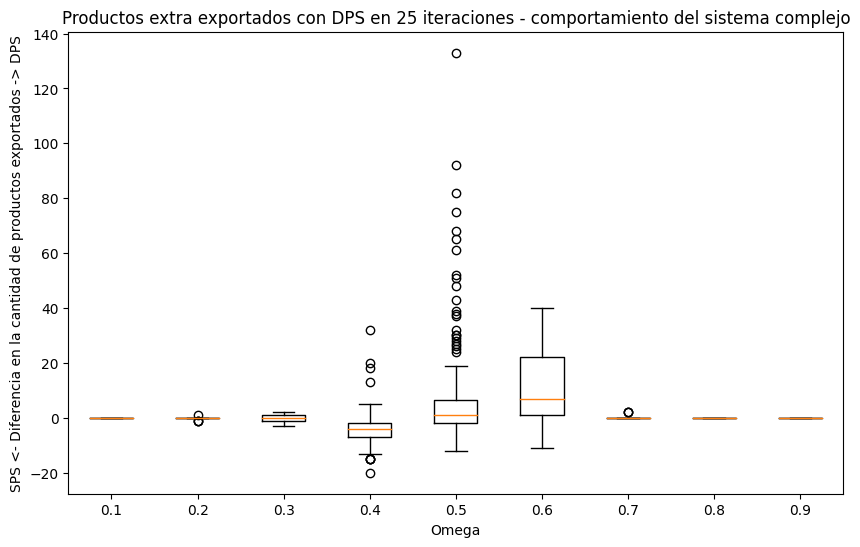

In [56]:
plot_dps_vs_sps_boxplot(list(M.index), resultados_nuevos, f"comportamiento del sistema complejo", max_it=25, saveit=True)

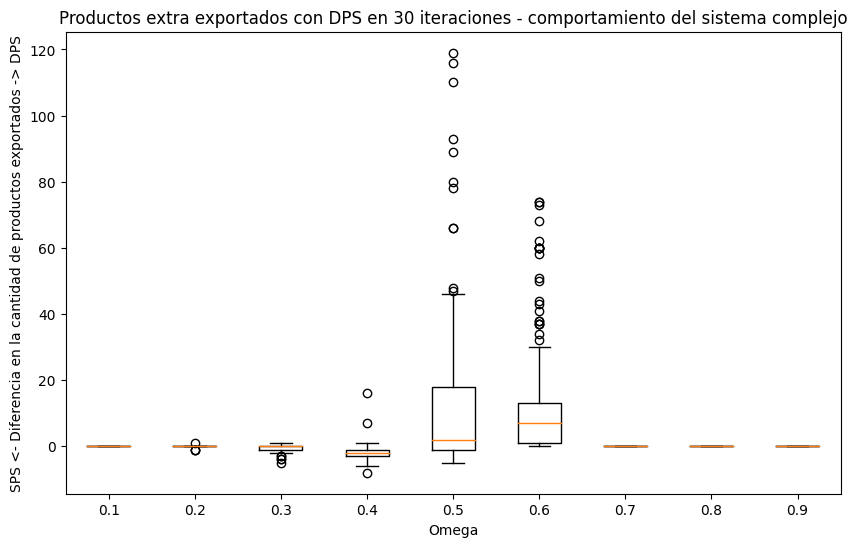

In [57]:
plot_dps_vs_sps_boxplot(list(M.index), resultados_nuevos, f"comportamiento del sistema complejo", max_it=30, saveit=True)

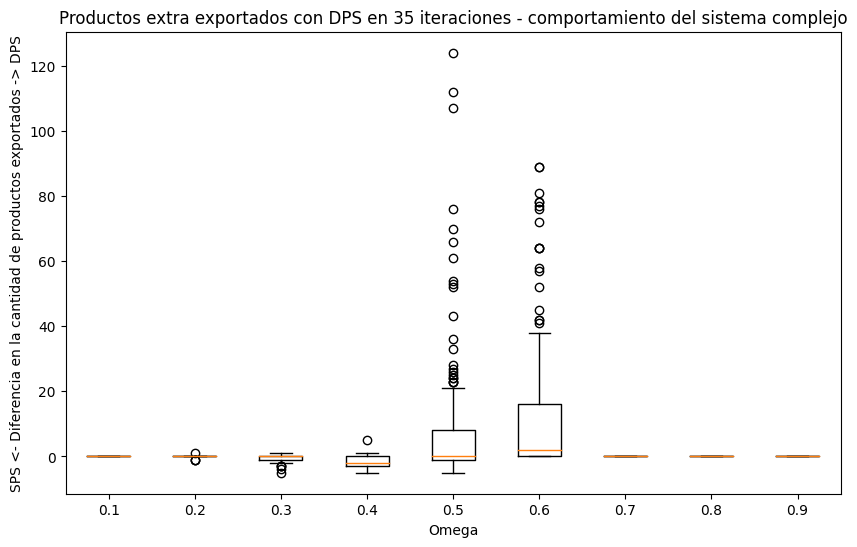

In [58]:
plot_dps_vs_sps_boxplot(list(M.index), resultados_nuevos, f"comportamiento del sistema complejo", max_it=35, saveit=True)

# usando este $\Omega$ graficamos:

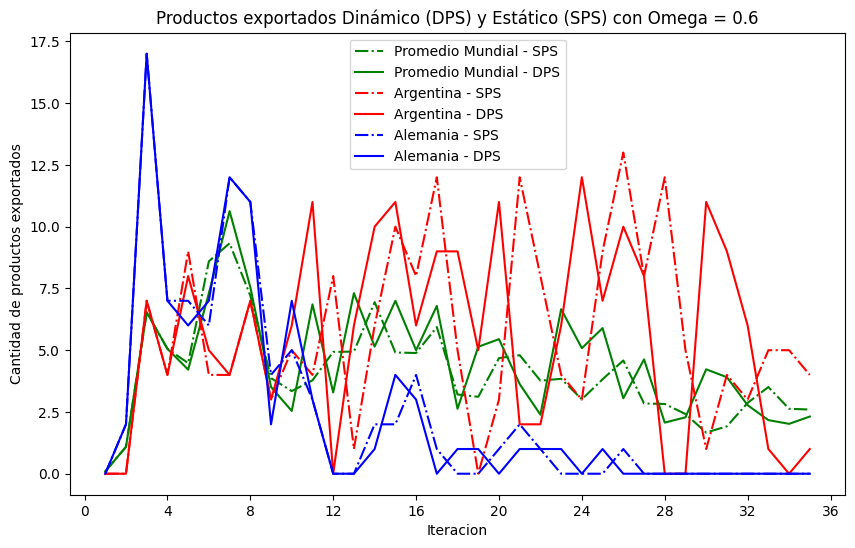

In [59]:
resultados_nuevos_dict = {}
for (spd_hist, dps_hist, omega) in resultados_nuevos:
    resultados_nuevos_dict[omega] = (spd_hist, dps_hist)

spd_hist, dps_hist = resultados_nuevos_dict[0.6]
plot_sps_vs_dps(spd_hist, dps_hist, 0.6, saveit=True)

#TODO: Elegir uno de los $\Omega$ para mostrar diferencia entre Arg y Alemania

# TODO: enfocarse solo en las últimas iteraciones; hacer lo mismo para cigarras y hormigas

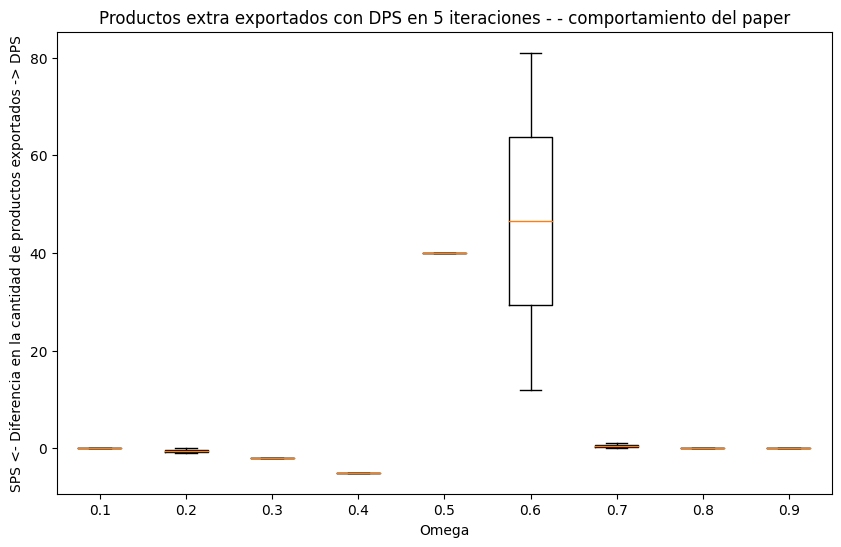

In [60]:
plot_dps_vs_sps_boxplot(["Argentina", "Germany"], resultados_paper, "- comportamiento del paper")

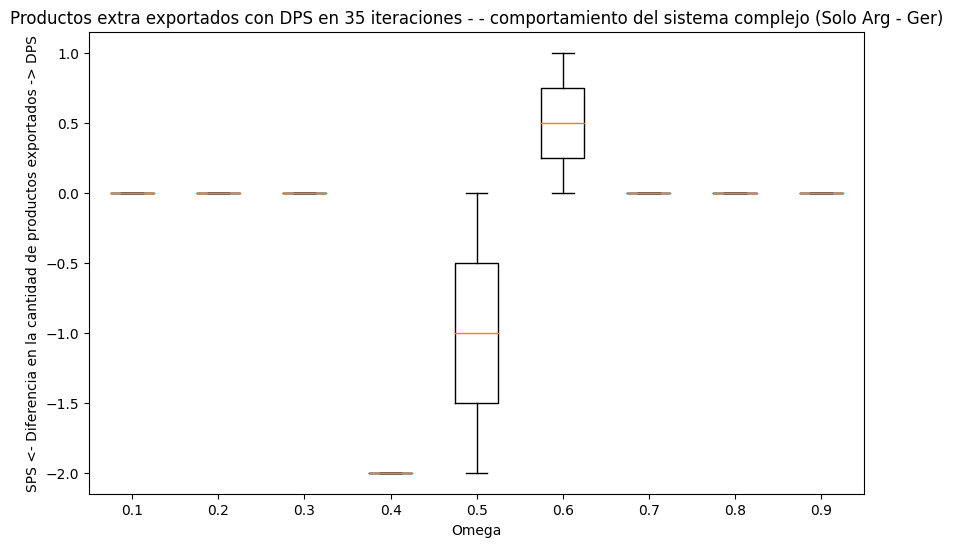

In [61]:
plot_dps_vs_sps_boxplot(["Argentina", "Germany"], resultados_nuevos, 
                        "- comportamiento del sistema complejo (Solo Arg - Ger)")